# Introducción al aprendizaje por refuerzo y Q-Learning

El aprendizaje por refuerzo involucra tres conceptos importantes: el agente, algunos estados y un conjunto de acciones por estado. Al ejecutar una acción en un estado específico, el agente recibe una recompensa. Imaginemos de nuevo el juego de ordenador Super Mario. Eres Mario, estás en un nivel de juego, parado al lado de un acantilado. Arriba de ti hay una moneda. Tú siendo Mario, en un nivel de juego, en una posición específica... ese es tu estado. Mover un paso hacia la derecha (una acción) te llevará al límite y eso te daría una puntuación numérica baja. Sin embargo, presionar el botón de salto te permitiría sumar un punto y seguirías con vida. Ese es un resultado positivo y debería otorgarle una puntuación numérica positiva.

Al utilizar el aprendizaje por refuerzo y un simulador (el juego), puedes aprender a jugar para maximizar la recompensa, que es permanecer con vida y obtener tantos puntos como sea posible.

## Introducción
En esta lección, exploraremos el mundo de **[Pedro y el lobo](https://en.wikipedia.org/wiki/Peter_and_the_Wolf)** , inspirado en un cuento de hadas musical del compositor ruso, [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Usaremos el aprendizaje por refuerzo para permitir que Peter explore su entorno, recolecte manzanas sabrosas y evite encontrarse con el lobo.

**El aprendizaje por refuerzo** (RL) es una técnica de aprendizaje que nos permite aprender el comportamiento óptimo de un agente en algún **entorno** mediante la ejecución de muchos experimentos. Un agente en este entorno debería tener algún objetivo , definido por una **función de recompensa**.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## El entorno

Para simplificar, consideremos que el mundo de Peter es un tablero cuadrado de tamaño widthx height, como este:

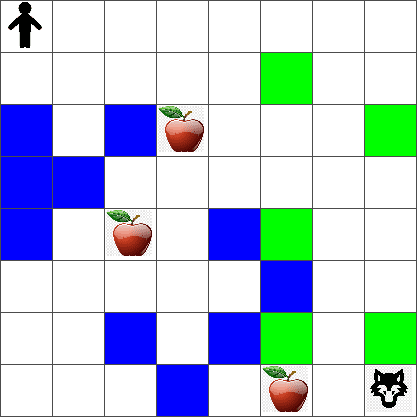

Cada celda de este tablero puede ser:

* suelo , sobre el cual Pedro y otras criaturas pueden caminar.
* agua , sobre la cual obviamente no se puede caminar.
* un árbol o pasto , un lugar donde poder descansar.
* una manzana , que representa algo que Peter estaría feliz de encontrar para poder alimentarse.
* un lobo , que es peligroso y debe evitarse.

Hay un módulo de Python independiente, rlboard.pyque contiene el código para trabajar con este entorno. Debido a que este código no es importante para comprender nuestros conceptos, importaremos el módulo y lo usaremos para crear el tablero de muestra (bloque de código 1):

In [ ]:
from rlboard import *

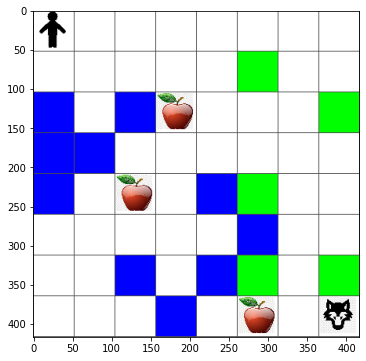

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

Este código imprime una imagen del entorno similar a la de arriba.

## Acciones y política
En nuestro ejemplo, el objetivo de Peter sería poder encontrar una manzana, evitando al mismo tiempo al lobo y otros obstáculos. Para hacer esto, básicamente puede caminar hasta encontrar una manzana.

Por tanto, en cualquier posición, podrá elegir entre una de las siguientes acciones: arriba, abajo, izquierda y derecha.

Definiremos esas acciones como un diccionario y las asignaremos a pares de cambios de coordenadas correspondientes. Por ejemplo, moverse hacia la derecha ( R) correspondería a un par (1,0). (bloque de código 2):

In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

En resumen, la estrategia y el objetivo de este escenario son los siguientes:

* La estrategia de nuestro agente (Peter) está definida por la llamada política . Una política es una función que devuelve la acción en cualquier estado determinado. En nuestro caso, el estado del problema está representado por el tablero, incluida la posición actual del jugador.

* El objetivo del aprendizaje por refuerzo es eventualmente aprender una buena política que nos permita resolver el problema de manera eficiente. Sin embargo, como punto de partida, consideremos la política más simple llamada paseo aleatorio .

### Caminata aleatoria
Primero resolvamos nuestro problema implementando una estrategia de paseo aleatorio. Con paseo aleatorio, elegiremos aleatoriamente la siguiente acción de las permitidas, hasta llegar a la manzana (bloque de código 3).

Implemente el paseo aleatorio con el siguiente código:

In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

La llamada a walkdebe devolver la longitud de la ruta correspondiente, que puede variar de una ejecución a otra.

Ejecute el experimento de caminata varias veces (digamos, 100) e imprima las estadísticas resultantes (bloque de código 4):

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


Tenga en cuenta que la longitud media de un camino es de unos 30 a 40 pasos, lo cual es bastante, teniendo en cuenta que la distancia media hasta la manzana más cercana es de unos 5 a 6 pasos.

También puedes ver cómo se ve el movimiento de Peter durante el paseo aleatorio:

### Función de recompensa
Para que nuestra política sea más inteligente, debemos comprender qué medidas son "mejores" que otras. Para hacer esto, necesitamos definir nuestro objetivo.

El objetivo se puede definir en términos de una función de recompensa , que devolverá un valor de puntuación para cada estado. Cuanto mayor sea el número, mejor será la función de recompensa. (bloque de código 5)

In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

Un aspecto interesante de las funciones de recompensa es que, en la mayoría de los casos, solo recibimos una recompensa sustancial al final del juego . Esto significa que nuestro algoritmo debería recordar de alguna manera los "buenos" pasos que conducen a una recompensa positiva al final y aumentar su importancia. Del mismo modo, se deben desalentar todas las medidas que conduzcan a malos resultados.

## Q-Learning

Un algoritmo que discutiremos aquí se llama **Q-Learning** . En este algoritmo, la política está definida por una función (o estructura de datos) llamada **Q-Table** . Registra la "bondad" de cada una de las acciones en un estado determinado.

Se llama Q-Table porque a menudo resulta conveniente representarla como una tabla o una matriz multidimensional. Dado que nuestro tablero tiene dimensiones `width` x `height`, podemos representar la Q-Table usando una matriz numerosa con forma width x heightx len(actions): (bloque de código 6)

In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Observe que inicializamos todos los valores de Q-Table con un valor igual, en nuestro caso - 0,25. Esto corresponde a la política de "paseo aleatorio", porque todos los movimientos en cada estado son igualmente buenos. Podemos pasar la Q-Table a la plotfunción para visualizar la tabla en el tablero: m.plot(Q).

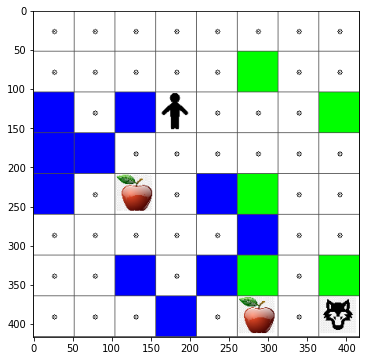

In [9]:
m.plot(Q)

En el centro de cada celda hay una "flecha" que indica la dirección de movimiento preferida. Como todas las direcciones son iguales, se muestra un punto.

Ahora necesitamos ejecutar la simulación, explorar nuestro entorno y aprender una mejor distribución de los valores de Q-Table, lo que nos permitirá encontrar el camino a la manzana mucho más rápido.

## Esencia del Q-Learning: ecuación de Bellman
Una vez que empecemos a movernos, cada acción tendrá su recompensa correspondiente, es decir, teóricamente podremos seleccionar la siguiente acción en función de la recompensa inmediata más alta. Sin embargo, en la mayoría de los estados, la medida no logrará nuestro objetivo de llegar a la manzana y, por lo tanto, no podemos decidir de inmediato qué dirección es mejor.

Recuerda que no importa el resultado inmediato, sino el resultado final, que obtendremos al final de la simulación.

Para tener en cuenta esta recompensa retrasada, necesitamos utilizar los principios de programación dinámica , que nos permiten pensar en nuestro problema de forma recursiva.

Supongamos que ahora estamos en el estado s y queremos pasar al siguiente estado s' . Al hacerlo, recibiremos la recompensa inmediata r(s,a) , definida por la función de recompensa, más alguna recompensa futura. Si suponemos que nuestra Q-Table refleja correctamente el "atractivo" de cada acción, entonces en el estado s' elegiremos una acción a que corresponda al valor máximo de Q(s',a') . Por lo tanto, la mejor recompensa futura posible que podríamos obtener en el estado s se definirá como maxa' Q(s',a') (aquí el máximo se calcula sobre todas las acciones posibles a' en el estado s' ).

Esto proporciona la fórmula de Bellman para calcular el valor de Q-Table en el estado s , dada la acción a :



## Algoritmo de aprendizaje
Dada la ecuación anterior, ahora podemos escribir pseudocódigo para nuestro algoritmo de aprendizaje:

* Inicialice Q-Table Q con números iguales para todos los estados y acciones
* Establecer tasa de aprendizaje α ← 1
* Repetir la simulación muchas veces.
    1. Comience en una posición aleatoria
    1.  Repetir
        1. Seleccione una acción a en el estado s
        2. Ejecutar la acción trasladándose a un nuevo estado .
        3. Si nos encontramos con una condición de final del juego o la recompensa total es demasiado pequeña, salimos de la simulación.
        4. Calcular la recompensa r en el nuevo estado
        5. Actualizar función Q según la ecuación de Bellman: Q(s,a) ← (1-α)Q(s,a)+α(r+γ max a' Q(s',a'))
        6. s ← s'
        7. Actualice la recompensa total y disminuya α.

## Explotar versus explorar
En el algoritmo anterior, no especificamos cómo exactamente deberíamos elegir una acción en el paso 2.1. Si elegimos la acción al azar, exploraremos el entorno al azar, y es muy probable que muramos con frecuencia, además de explorar áreas a las que normalmente no iríamos. Un enfoque alternativo sería explotar los valores de Q-Table que ya conocemos y así elegir la mejor acción (con un valor de Q-Table más alto) en el estado s . Sin embargo, esto nos impedirá explorar otros estados y es probable que no encontremos la solución óptima.

Por tanto, el mejor enfoque es lograr un equilibrio entre exploración y explotación. Esto se puede hacer eligiendo la acción en el estado s con probabilidades proporcionales a los valores en la Q-Table. Al principio, cuando los valores de Q-Table son todos iguales, correspondería a una selección aleatoria, pero a medida que aprendemos más sobre nuestro entorno, sería más probable que siguiéramos la ruta óptima y permitiéramos al agente elegir el camino inexplorado. de vez en cuando.

## Implementación de Python
Ahora estamos listos para implementar el algoritmo de aprendizaje. Antes de hacer eso, también necesitamos alguna función que convierta números arbitrarios en la Q-Table en un vector de probabilidades para las acciones correspondientes.

1. Crea una función probs():

In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Agregamos algunos epsal vector original para evitar la división por 0 en el caso inicial, cuando todos los componentes del vector son idénticos.

Ejecute el algoritmo de aprendizaje a través de 5000 experimentos, también llamados épocas : (bloque de código 8)

In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Después de ejecutar este algoritmo, la Q-Table debe actualizarse con valores que definan el atractivo de diferentes acciones en cada paso. Podemos intentar visualizar la Q-Table trazando un vector en cada celda que apuntará en la dirección de movimiento deseada. Para simplificar, dibujamos un pequeño círculo en lugar de una punta de flecha.
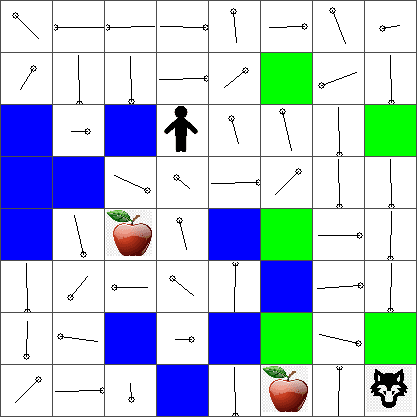

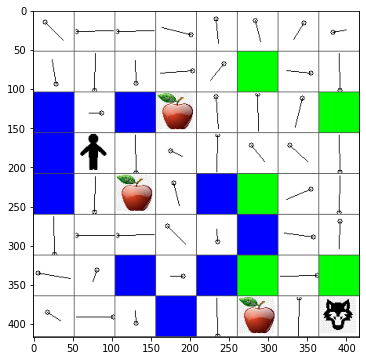

In [12]:
m.plot(Q)

## Comprobando la póliza
Dado que Q-Table enumera el "atractivo" de cada acción en cada estado, es bastante fácil usarla para definir la navegación eficiente en nuestro mundo. En el caso más simple, podemos seleccionar la acción correspondiente al valor más alto de Q-Table: (bloque de código 9)

In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

> Si prueba el código anterior varias veces, puede notar que a veces se "cuelga" y necesita presionar el botón DETENER en el cuaderno para interrumpirlo. Esto sucede porque podría haber situaciones en las que dos estados "apuntan" entre sí en términos de valor Q óptimo, en cuyo caso los agentes terminan moviéndose entre esos estados indefinidamente.

> **Tarea 1**: modifique la walkfunción para limitar la longitud máxima de la ruta en una cierta cantidad de pasos (digamos, 100) y observe cómo el código anterior devuelve este valor de vez en cuando.

> **Tarea 2**: Modificar la walkfunción para que no vuelva a los lugares donde ya estuvo anteriormente. Esto evitará walkque se produzca un bucle; sin embargo, el agente aún puede terminar "atrapado" en un lugar del que no pueda escapar.

## Navegación
Una mejor política de navegación sería la que utilizamos durante el entrenamiento, que combina explotación y exploración. En esta política, seleccionaremos cada acción con una cierta probabilidad, proporcional a los valores en la Q-Table. Esta estrategia aún puede resultar en que el agente regrese a una posición que ya ha explorado, pero, como puede ver en el código siguiente, da como resultado una ruta promedio muy corta hasta la ubicación deseada (recuerde que print_statisticsla simulación se ejecuta 100 veces). : (bloque de código 10)

In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


Después de ejecutar este código, debería obtener una longitud de ruta promedio mucho menor que antes, en el rango de 3 a 6.

## Investigando el proceso de aprendizaje
Como hemos mencionado, el proceso de aprendizaje es un equilibrio entre la exploración y la exploración del conocimiento adquirido sobre la estructura del espacio problemático. Hemos visto que los resultados del aprendizaje (la capacidad de ayudar a un agente a encontrar un camino corto hacia la meta) han mejorado, pero también es interesante observar cómo se comporta la longitud media del camino durante el proceso de aprendizaje:

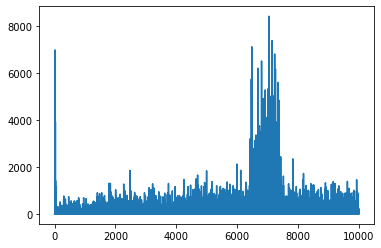

In [15]:
plt.plot(lpath)

Los aprendizajes se pueden resumir en:

* La longitud media del camino aumenta . Lo que vemos aquí es que al principio, la longitud promedio del camino aumenta. Probablemente esto se deba a que cuando no sabemos nada sobre el medio ambiente, es probable que quedemos atrapados en malos estados, agua o lobo. A medida que aprendemos más y empezamos a utilizar este conocimiento, podemos explorar el entorno durante más tiempo, pero todavía no sabemos muy bien dónde están las manzanas.

* La longitud del camino disminuye a medida que aprendemos más . Una vez que aprendemos lo suficiente, al agente le resulta más fácil lograr el objetivo y la longitud del camino comienza a disminuir. Sin embargo, todavía estamos abiertos a la exploración, por lo que a menudo nos desviamos del mejor camino y exploramos nuevas opciones, lo que hace que el camino sea más largo de lo óptimo.

* La longitud aumenta abruptamente . Lo que también observamos en este gráfico es que en algún momento la longitud aumentó abruptamente. Esto indica la naturaleza estocástica del proceso y que en algún momento podemos "estropear" los coeficientes de la Q-Table sobrescribiéndolos con nuevos valores. Idealmente, esto debería minimizarse disminuyendo la tasa de aprendizaje (por ejemplo, hacia el final del entrenamiento, solo ajustamos los valores de Q-Table en un valor pequeño).

En general, es importante recordar que el éxito y la calidad del proceso de aprendizaje dependen significativamente de parámetros como la tasa de aprendizaje, la caída de la tasa de aprendizaje y el factor de descuento. A menudo se les llama hiperparámetros , para distinguirlos de los parámetros que optimizamos durante el entrenamiento (por ejemplo, coeficientes de Q-Table). El proceso de encontrar los mejores valores de hiperparámetros se llama optimización de hiperparámetros y merece un tema aparte.